In [1]:
using Revise
using Molly
using Unitful
using ConstrainedDynamicsSimulator

[ Info: Precompiling ConstrainedDynamicsSimulator [c57ba902-cf0d-4687-8605-981b463e8666] (cache misses: include_dependency fsize change (4), incompatible header (10), mismatched flags (2))


In [6]:
# TODO: might still need to worry about boundary issues
ff_dir = joinpath(dirname(pathof(Molly)), "..", "data", "force_fields")
ff = MolecularForceField(joinpath.(ff_dir, ["ff99SBildn.xml", "tip3p_standard.xml"])...)
sys = System("dipeptide_nowater.pdb", ff; rename_terminal_res=false)

function phi_wrapper(sys, args...; kwargs...)
    rad2deg(torsion_angle(sys.coords[5], sys.coords[7], sys.coords[9],
                          sys.coords[15], sys.boundary))
end

function psi_wrapper(sys, args...; kwargs...)
    rad2deg(torsion_angle(sys.coords[7], sys.coords[9], sys.coords[15],
                          sys.coords[17], sys.boundary))
end

sys = System(
    "dipeptide_nowater.pdb",
    ff;
    rename_terminal_res=false,
    loggers=(
        writer=StructureWriter(100, "trajectory.pdb"),
        phi=GeneralObservableLogger(phi_wrapper, Float64, 100),
        psi=GeneralObservableLogger(psi_wrapper, Float64, 100),
    ),
    implicit_solvent="gbn2",
)

temp = 3.0u"K"
timestep = 0.002u"ps"
fric = 5000.0u"ps^-1"
simulator = ConstrainedDynamicsSimulator.CVConstrainedOverdampedLangevin(dt=timestep, T=temp, γ=fric, φ_grid=ConstrainedDynamicsSimulator.Dihedrals.φ_grid, φ_flat=ConstrainedDynamicsSimulator.Dihedrals.φ_flat)

ConstrainedDynamicsSimulator.CVConstrainedOverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}, typeof(ConstrainedDynamicsSimulator.Dihedrals.φ_grid), typeof(ConstrainedDynamicsSimulator.Dihedrals.φ_flat)}(0.002 ps, 3.0 K, 5000.0 ps⁻¹, ConstrainedDynamicsSimulator.Dihedrals.φ_grid, ConstrainedDynamicsSimulator.Dihedrals.φ_flat, 1)

In [9]:
simulator = OverdampedLangevin(
    dt=timestep,
    temperature=temp,
    friction=fric,
)

OverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}}(0.002 ps, 4.0 K, 5000.0 ps⁻¹, 1)

In [ ]:
Molly.simulate!(sys, simulator, 100000)

In [7]:
ConstrainedDynamicsSimulator.PVD2!(sys, simulator, 10_000) # This will take a little while to run

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


System with 22 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[3.4224000000000006 nm, 3.9133000000000004 nm, 3.3010999999999995 nm])

In [ ]:
# TODO: We need to investigate how multiprocessing works with Zigote and ForwardDIff in Julia

In [8]:
phi_values = values(sys.loggers.phi)
psi_values = values(sys.loggers.psi)

101-element Vector{Float64}:
 160.7338408636881
 163.58845656086777
 164.21487536755663
 164.58395050224885
 163.90783966146068
 164.0001400434573
 164.56195595589517
 165.36181726192177
 165.7145439357834
 165.04949896393924
 164.80283955447425
 164.78674956907872
 165.21248032877648
   ⋮
 160.70855261177007
 161.25857184298508
 161.5385459872821
 160.31213567269805
 161.39346183385067
 161.61506911817622
 161.30430449697482
 161.84119045032486
 162.3999953051447
 161.24776214028782
 162.46211894429575
 162.3205464540547

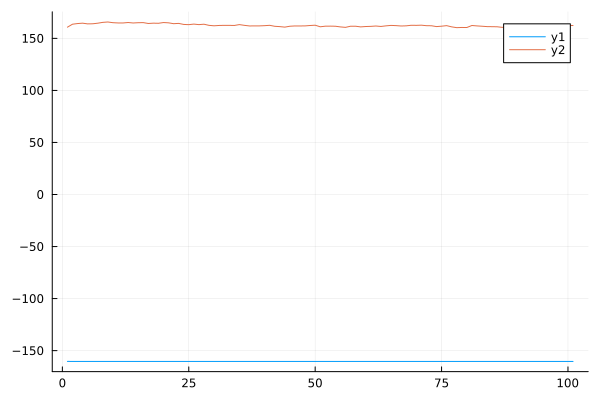

In [9]:
# This is with the default integrator

using Plots

plot(phi_values)
plot!(psi_values)

In [ ]:
using Statistics
using Molly
using ConstrainedDynamicsSimulator
using Unitful
using CSV
using DataFrames
using Threads

function init_system(logging_interval)
    ff_dir = joinpath(dirname(pathof(Molly)), "..", "data", "force_fields")
    ff = MolecularForceField(joinpath.(ff_dir, ["ff99SBildn.xml", "tip3p_standard.xml"])...)
    sys = System("dipeptide_nowater.pdb", ff; rename_terminal_res=false)

    function phi_wrapper(sys, args...; kwargs...)
        rad2deg(torsion_angle(sys.coords[5], sys.coords[7], sys.coords[9],
                            sys.coords[15], sys.boundary))
    end

    function psi_wrapper(sys, args...; kwargs...)
        rad2deg(torsion_angle(sys.coords[7], sys.coords[9], sys.coords[15],
                            sys.coords[17], sys.boundary))
    end

    sys = System(
        "dipeptide_nowater.pdb",
        ff;
        rename_terminal_res=false,
        loggers=(
            phi=GeneralObservableLogger(phi_wrapper, Float64, logging_interval),
            psi=GeneralObservableLogger(psi_wrapper, Float64, logging_interval),
        ),
        implicit_solvent="gbn2",
    )

    return sys
end

timestep = 0.002u"ps"
fric = 5000.0u"ps^-1"
temps = [3 * 10^(x) for x in 0:0.1:3]
traj_length = 1_000
logging_interval = 1
phi_data_array = zeros((length(temps), div(traj_length, logging_interval) + 1))
psi_data_array = zeros((length(temps), div(traj_length, logging_interval) + 1))
mean_phi_increment = zeros(length(temps))
mean_psi_increment = zeros(length(temps))

@threads for (idx, temp) in enumerate(temps)
    sys = init_system(logging_interval)
    temp = temp*u"K"
    simulator = CVConstrainedOverdampedLangevin(dt=timestep, T=temp, γ=fric, φ_grid=ConstrainedDynamicsSimulator.Dihedrals.φ_grid, φ_flat=ConstrainedDynamicsSimulator.Dihedrals.φ_flat)
    ConstrainedDynamicsSimulator.simulate!(sys, simulator, traj_length)
    phi_data_array[idx, :] = values(sys.loggers.phi)
    psi_data_array[idx, :] = values(sys.loggers.psi)
    mean_phi_increment[idx] = mean(abs.(diff(values(sys.loggers.phi))))
    mean_psi_increment[idx] = mean(abs.(diff(values(sys.loggers.psi))))
end

mean_phi_angles = vec(mean(phi_data_array, dims=2))
mean_psi_angles = vec(mean(psi_data_array, dims=2))
std_phi_angles = vec(std(phi_data_array, dims=2))
std_psi_angles = vec(std(psi_data_array, dims=2))

df = DataFrame(
    Temperature_K = temps,
    Mean_Phi_Angles = mean_phi_angles,
    Std_Phi_Angles = std_phi_angles,
    Mean_Phi_Increment = mean_phi_increment,
    Mean_Psi_Angles = mean_psi_angles,
    Std_Psi_Angles = std_psi_angles,
    Mean_Psi_Increment = mean_psi_increment
)

metadata = """
# Timestep: $(timestep)
# Friction Coefficient: $(fric)
# Trajectory Length: $(traj_length) steps
# Logging Interval: $(logging_interval)
# Temperature Range: $(minimum(temps)) K to $(maximum(temps)) K
# Number of Temperatures: $(length(temps))
"""

open("./results/EM/mean_and_std_angles.csv", "w") do io
    write(io, metadata)
    CSV.write(io, df; append=true, writeheader=true)
end

println("Results saved to mean_and_std_angles.csv")

progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 144336173941)), 0, 1, false, false, 1.742397775215447e9, 1.742397775215447e9, 1.742397775215447e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4300722896, 4300513024, -1)), 0, 1, false, false, 1.742397775427767e9, 1.742397775427767e9, 1.742397775427767e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (5709910320, 5709910352, 431792399119)), 0, 1, false, false, 1.742397775633433e9, 1.742397775633433e9, 1.742397775633433e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 2377900747084643388)), 0, 1, false, false, 1.742397775833764e9, 1.742397775833764e9, 1.742397775833764e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 141733920768)), 0, 1, false, false, 1.742397776075817e9, 1.742397776075817e9, 1.742397776075817e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 144336173941)), 0, 1, false, false, 1.742397776277502e9, 1.742397776277502e9, 1.742397776277502e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (5, 6, -281333242789888)), 0, 1, false, false, 1.742397776479636e9, 1.742397776479638e9, 1.742397776479638e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397776678322e9, 1.742397776678322e9, 1.742397776678322e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (7, 0, -1)), 0, 1, false, false, 1.742397776879789e9, 1.742397776879789e9, 1.742397776879789e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 430036378497)), 0, 1, false, false, 1.742397777082881e9, 1.742397777082881e9, 1.742397777082881e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397777282821e9, 1.742397777282821e9, 1.742397777282821e9))

Progress:  51%|████████████████████▉                    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 14, 141733920768)), 0, 1, false, false, 1.74239777748339e9, 1.74239777748339e9, 1.74239777748339e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4664767233, 1, 22)), 0, 1, false, false, 1.742397777685163e9, 1.742397777685163e9, 1.742397777685163e9))

Progress:  50%|████████████████████▋                    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (13152099329, 1, 22)), 0, 1, false, false, 1.742397777934899e9, 1.742397777934899e9, 1.742397777934899e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, -281330640536715)), 0, 1, false, false, 1.742397778137442e9, 1.742397778137442e9, 1.742397778137442e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4610916787295108353, 1, 22)), 0, 1, false, false, 1.742397778337591e9, 1.742397778337591e9, 1.742397778337591e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.74239777853844e9, 1.74239777853844e9, 1.74239777853844e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 430036378497)), 0, 1, false, false, 1.742397778736625e9, 1.742397778736625e9, 1.742397778736625e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397778942657e9, 1.742397778942657e9, 1.742397778942657e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4611859651306884353, 1, 22)), 0, 1, false, false, 1.74239777913884e9, 1.74239777913884e9, 1.74239777913884e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 4703380704)), 0, 1, false, false, 1.742397779341487e9, 1.742397779341487e9, 1.742397779341487e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397779547172e9, 1.742397779547172e9, 1.742397779547172e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (2, 1, 431322352720)), 0, 1, false, false, 1.742397779753839e9, 1.742397779753839e9, 1.742397779753839e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (5714805200, 4705868944, 4703380704)), 0, 1, false, false, 1.742397779999227e9, 1.742397779999227e9, 1.742397779999227e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397780203213e9, 1.742397780203213e9, 1.742397780203213e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.74239778040032e9, 1.74239778040032e9, 1.74239778040032e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4610890368634902137, 4610135022540745064, 22)), 0, 1, false, false, 1.742397780605907e9, 1.742397780605907e9, 1.742397780605908e9))

Progress:  51%|████████████████████▉                    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397780808183e9, 1.742397780808183e9, 1.742397780808183e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, -281330640536715)), 0, 1, false, false, 1.742397781010801e9, 1.742397781010801e9, 1.742397781010801e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4611468723124210433, 1, 22)), 0, 1, false, false, 1.742397781213911e9, 1.742397781213911e9, 1.742397781213911e9))

Progress:  51%|█████████████████████▏                   |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4568645510995893283, 5694363216, 22)), 0, 1, false, false, 1.742397781415803e9, 1.742397781415803e9, 1.742397781415803e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Results saved to mean_and_std_angles.csv
